# Abstract

Try to implement [homography estimation](https://cmp.felk.cvut.cz/~chum/papers/chum-icpr12.pdf).

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from functools import partial
from itertools import cycle
from time import perf_counter
from tabulate import tabulate
import cv2 as cv

from cirtorch.datasets.testdataset import configdataset
from cirtorch.utils.evaluate import compute_map_and_print
from asmk import io_helpers, ASMKMethod, functional, hamming
from examples.demo_how import build_ivf, query_ivf

In [2]:
def get_packed_residuals(vecs, centroids, binary=True):
    residuals = vecs - centroids
    
    if binary:
        return hamming.binarize_and_pack_2D(residuals)
    else:
        return functional.normalize_vec_l2(residuals)
    
def generate_hypotheses(coordx1, coordy1, scales1, coordx2, coordy2, scales2):
    # 1 -> 2
    m = np.tile(np.eye(3), [coordx1.size, 1, 1])
    s = scales2 / scales1
    
    m[:, 0, 2] = -1 * coordx1 * s + coordx2
    m[:, 1, 2] = -1 * coordy1 * s + coordy2
    m[:, 0, 0] = m[:, 1, 1] = s
    
    return m


def compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2):
    pts1 = np.vstack([coordx1, coordy1, np.ones_like(coordx1)])
    pts2 = np.vstack([coordx2, coordy2])
    
    # [number of hypotheses, 3, number of correspondences]
    transformed_pts1 = hypotheses @ pts1
    transformed_pts1 /= transformed_pts1[:, -1:, :]
    
    # [number of hypotheses, number of correspondences]
    return np.linalg.norm(transformed_pts1[:, :-1, :] - pts2, axis=1)


def verify_single_model(errors, corrs, inlier_threshold=32):
    n = corrs.shape[0]
    mask = np.zeros([n], dtype=bool)
    taken = set()

    i = 0
    actual_y, best_index = None, None
    best_error = None
    while i < n:
        actual_y = corrs[i, 1]
        
        best_error = np.inf
        best_index = -1
        while i < n and actual_y == corrs[i, 1]:
            if errors[i] < best_error and corrs[i, 0] not in taken:
                best_error = errors[i]
                best_index = i
            i += 1
        
        if best_error <= inlier_threshold:
            mask[best_index] = True
            taken.add(corrs[best_index, 0])
    
    return mask


def verify_models(errors, corrs, inlier_threshold=32):
    return np.apply_along_axis(
        partial(verify_single_model, corrs=corrs, inlier_threshold=inlier_threshold),
        axis=1,
        arr=errors,
    )


def affine_local_optimization(A, coordx1, coordy1, coordx2, coordy2):
    size = coordx1.size
    
    if size < 3:
        return A
    
    weight = 2 * np.pi if size < 11 else 0
    r2h = 50.0  # half of squared circle radius is integrated over
    
    mx1, my1 = coordx1.mean(), coordy1.mean()
    mx2, my2 = coordx2.mean(), coordy2.mean()
    
    dx1, dy1 = (coordx1 - mx1), (coordy1 - my1)
    dx2, dy2 = (coordx2 - mx2), (coordy2 - my2)
    
    # Compute AtA, AtB1, AtB2
    AtA = [0.0, 0.0, 0.0]
    AtB1 = [0.0, 0.0]
    AtB2 = [0.0, 0.0]
    
    AtA[0] = ((1 + weight) * dx1 * dx1 + weight * r2h).sum()
    AtA[1] = ((1 + weight) * dx1 * dy1).sum()
    AtA[2] = ((1 + weight) * dy1 * dy1 + weight * r2h).sum()
    
    AtB1[0] = ((1 + weight) * dx1 * dx2 + weight * A[0, 0] * r2h).sum()
    AtB1[1] = ((1 + weight) * dy1 * dx2 + weight * A[0, 1] * r2h).sum()
    
    AtB2[0] = ((1 + weight) * dx1 * dy2 + weight * A[1, 0] * r2h).sum()
    AtB2[1] = ((1 + weight) * dy1 * dy2 + weight * A[1, 1] * r2h).sum()
    
    # Final affine transformation
    detAtA = AtA[0] * AtA[2] - AtA[1] * AtA[1]
    if detAtA == 0:
        raise ValueError('Determinant equals to zero.')
        
    norm = 1 / detAtA
    H0 = (AtA[2] * AtB1[0] - AtA[1] * AtB1[1]) * norm
    H1 = (-AtA[1] * AtB1[0] + AtA[0] * AtB1[1]) * norm
    H2 = mx2 - mx1 * H0 - my1 * H1
    H3 = (AtA[2] * AtB2[0] - AtA[1] * AtB2[1]) * norm
    H4 = (-AtA[1] * AtB2[0] + AtA[0] * AtB2[1]) * norm
    H5 = my2 - mx1 * H3 - my1 * H4
    
    H = np.array([
        [H0, H1, H2],
        [H3, H4, H5],
        [0, 0, 1],
    ])
    
    return H


def get_tentative_correspondencies(
    q_ids, db_ids, q_residual_packs, db_residual_packs, similarity_func, max_tc=1500, max_MxN=15,
):
    db_unique, db_counts = np.unique(db_ids, return_counts=True)
    q_unique, q_counts = np.unique(q_ids, return_counts=True)
    
    db_sorted = np.argsort(db_ids)
    q_sorted = np.argsort(q_ids)
    
    ret = []
    similarities = []
    # counts = []
    
    qr_i = 0  # query index
    db_i = 0  # database index
    s_qr_i = 0  # sorted query index
    s_db_i = 0  # sorted database index

    qr_len = q_unique.shape[0]
    db_len = db_unique.shape[0]
    s_qry_len = q_sorted.shape[0]
    s_rel_len = db_sorted.shape[0]
    
    while qr_i < qr_len and db_i < db_len:  # While there are any visual words remaining
        if q_unique[qr_i] == db_unique[db_i]:  # If we encountered the the same visual word
            # count = q_counts[qr_i] * db_counts[db_i]
            # if count <= max_MxN:
            if True:
            
                # Move the sorted indexes forward so we find the beginning of current visual word
                while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] != q_unique[qr_i]:
                    s_qr_i += 1
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] != db_unique[db_i]:
                    s_db_i += 1
                
                # Cross products of corresponding visual words
                count = q_counts[qr_i] * db_counts[db_i]
                cross_product_correspondences = np.zeros([count, 2])
                cross_product_similarities = np.zeros([count])
                cross_product_index = 0
                
                s_qr_i_start = s_qr_i
                while s_db_i < s_rel_len and db_ids[db_sorted[s_db_i]] == db_unique[db_i]:
                    s_qr_i = s_qr_i_start
                    while s_qr_i < s_qry_len and q_ids[q_sorted[s_qr_i]] == q_unique[qr_i]:
                        #ret.append([q_sorted[s_qr_i], db_sorted[s_db_i]])
                        #similarities.append(similarity_func(
                        #    q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        #)[0])
                        #vw_ids.append(q_unique[qr_i])
                        
                        cross_product_correspondences[cross_product_index] = [q_sorted[s_qr_i], db_sorted[s_db_i]]
                        cross_product_similarities[cross_product_index] = similarity_func(
                            q_residual_packs[q_sorted[s_qr_i]], db_residual_packs[db_sorted[s_db_i]]
                        )[0]
                        cross_product_index += 1
                        
                        s_qr_i += 1
                    s_db_i += 1
                    
                if count <= max_MxN:
                    mask = np.ones_like(cross_product_similarities, dtype=bool)
                else:
                    threshold = -np.sort(-cross_product_similarities)[max_MxN]
                    mask = cross_product_similarities >= threshold
                    
                ret.extend(cross_product_correspondences[mask][:max_MxN])
                similarities.extend(cross_product_similarities[mask][:max_MxN])
                    
            qr_i += 1
            db_i += 1
        elif q_unique[qr_i] < db_unique[db_i]:
            qr_i += 1
        else:
            db_i += 1
            
    ret_np = np.array(ret, dtype=int, ndmin=2)
        
    # If there are way too many correspondences, crop the result
    similarities_np = np.array(similarities)
    if ret_np.shape[0] > max_tc:
        # counts_np = np.array(counts)
        # keys = np.argsort(counts, kind='stable')[:max_tc]
        # return ret_np[keys]
        
        # If we do not care about the order
        #
        # keys = np.argsort(-similarities_np, kind='stable')[:max_tc]
        # return ret_np[keys], similarities_np[keys]
        
        # If we want to preserve the order (same visual words in a row)
        
        threshold = -np.sort(-similarities_np)[max_tc]
        mask = similarities_np >= threshold
        
        return ret_np[mask][:max_tc], similarities_np[mask][:max_tc]

    return ret_np, similarities_np


def kernel_similarity(v1, v2):
    _, sim = asmk_dataset.kernel.similarity(v1, v2[np.newaxis], np.array([0]), alpha=1, similarity_threshold=-np.inf)
    return sim

In [3]:
def get_denormalizing_A(x, y, s):
    return np.array([
        [s, 0, x],
        [0, s, y],
        [0, 0, 1],
    ])



def A2toRH(N1, D1, N2, D2):
    """
    ┌ COPIED METHOD 
    │
    ├ Webpage: https://cmp.felk.cvut.cz/~chum/pub_all.html
    ├ Article: Homography Estimation from Correspondences of Local Elliptical Features
    ├ Link:    [Code]
    └ File:    A2toRH.m
    """
    
    def normpts(u1, u2):
        m = (u2 + u1) / 2
        d = (u1 - u2) / 2
        sc = np.sqrt(d[0]**2 + d[1]**2)
        if sc < 1:
            sc = 1
        iT = np.array([
            [sc, 0, m[0]],
            [0, sc, m[1]],
            [0, 0, 1],
        ])
        sc = 1 / sc
        T = np.array([
            [sc, 0, -m[0] * sc],
            [0, sc, -m[1] * sc],
            [0, 0, 1],
        ])
        return T, iT


    def trA(A):
        return np.array([*A[:2].ravel(), A[2, 2]])


    def getZ(u):
        Z = np.zeros((7, 9))
        Z[0, [0, 6]] = [-1, u[3]]
        Z[1, [1, 7]] = [-1, u[3]]
        Z[2, [2, 6, 7]] = [-1, -u[0] * u[3], -u[1] * u[3]]
        Z[3, [3, 6]] = [-1, u[4]]
        Z[4, [4, 7]] = [-1, u[4]]
        Z[5, [5, 6, 7]] = [-1, -u[0] * u[4], -u[1] * u[4]]
        Z[6, [8, 6, 7]] = [-1, -u[0], -u[1]]
        return Z
    

    def nd(A, B):
        A = A.ravel()
        B = B.ravel()
        Z = np.zeros((7, 3))
        Z[:, 2] = [0, 0, A[2], 0, 0, A[5], 1]
        Z[:, 0] = [A[1] * B[0] - A[0] * B[3], A[1] * B[1] - A[0] * B[4],
                   A[1] * B[2] - A[0] * B[5], A[4] * B[0] - A[3] * B[3],
                   A[4] * B[1] - A[3] * B[4], A[4] * B[2] - A[3] * B[5], 0]
        Z[:, 1] = [A[0] * B[0] + A[1] * B[3], A[0] * B[1] + A[1] * B[4],
                   A[0] * B[2] + A[1] * B[5], A[3] * B[0] + A[4] * B[3],
                   A[3] * B[1] + A[4] * B[4], A[3] * B[2] + A[4] * B[5], 0]
        return Z
    
    
    do_norm = True

    iN1 = np.linalg.inv(N1)
    iN2 = np.linalg.inv(N2)
    u1 = np.concatenate((iN1[:, 2], D1[:, 2]))
    u2 = np.concatenate((iN2[:, 2], D2[:, 2]))

    if do_norm:
        T1, iT1 = normpts(u1[:3], u2[:3])
        u1[:3] = np.dot(T1, u1[:3])
        u2[:3] = np.dot(T1, u2[:3])
        N1 = np.dot(N1, iT1)
        N2 = np.dot(N2, iT1)

        T2, iT2 = normpts(u2[3:], u1[3:])
        u1[3:] = np.dot(T2, u1[3:])
        u2[3:] = np.dot(T2, u2[3:])
        D1 = np.dot(T2, D1)
        D2 = np.dot(T2, D2)

    Z1 = np.hstack([getZ(u1), nd(D1, N1), np.zeros((7, 3))])
    Z2 = np.hstack([getZ(u2), np.zeros((7, 3)), nd(D2, N2)])
    Z = np.vstack((Z1, Z2))
    _, _, v = np.linalg.svd(Z)
    
    H = v[-1, :9].reshape((3, 3))

    if do_norm:
        H = np.dot(np.dot(iT2, H), T1)

    return H

In [4]:
def AntoRH(Ns, Ds):
    """
    ┌ COPIED METHOD 
    │
    ├ Webpage: https://cmp.felk.cvut.cz/~chum/pub_all.html
    ├ Article: Homography Estimation from Correspondences of Local Elliptical Features
    ├ Link:    [Code]
    └ File:    AntoRH.m
    """
    # Ds.shape = Ns.shape = [N, 3, 3]
    
    
    def trA(A):
        return np.array([*A[:2].ravel(), A[2, 2]])


    def getZ(u):
        Z = np.zeros((7, 9))
        Z[0, [0, 6]] = [-1, u[3]]
        Z[1, [1, 7]] = [-1, u[3]]
        Z[2, [2, 6, 7]] = [-1, -u[0] * u[3], -u[1] * u[3]]
        Z[3, [3, 6]] = [-1, u[4]]
        Z[4, [4, 7]] = [-1, u[4]]
        Z[5, [5, 6, 7]] = [-1, -u[0] * u[4], -u[1] * u[4]]
        Z[6, [8, 6, 7]] = [-1, -u[0], -u[1]]
        return Z
    
    def nd(A, B):
        A = A.ravel()
        B = B.ravel()
        Z = np.zeros((7, 3))
        Z[:, 2] = [0, 0, A[2], 0, 0, A[5], 1]
        Z[:, 0] = [A[1] * B[0] - A[0] * B[3], A[1] * B[1] - A[0] * B[4],
                   A[1] * B[2] - A[0] * B[5], A[4] * B[0] - A[3] * B[3],
                   A[4] * B[1] - A[3] * B[4], A[4] * B[2] - A[3] * B[5], 0]
        Z[:, 1] = [A[0] * B[0] + A[1] * B[3], A[0] * B[1] + A[1] * B[4],
                   A[0] * B[2] + A[1] * B[5], A[3] * B[0] + A[4] * B[3],
                   A[3] * B[1] + A[4] * B[4], A[3] * B[2] + A[4] * B[5], 0]
        return Z

    
    def p2e(u):
        e = u[:, 0:2] / (np.ones([1, 2]) * u[:, 2:3])
        return e
    
    def normu(u):
        if u.shape[1] == 3:
            u = p2e(u)

        m = np.mean(u, axis=0)
        u = u - m
        distu = np.sqrt(np.square(u).sum(axis=1))
        r = distu.mean() / np.sqrt(2)

        A = np.diag([1/r, 1/r, 1])
        A[:2, 2] = - m / r

        return A
    

    do_norm = True
    
    n = Ds.shape[0]
    u = np.hstack((np.linalg.inv(Ns)[:, :, 2], Ds[:, :, 2]))
    
    if do_norm:
        T1 = normu(u[:, :2])
        iT1 = np.linalg.inv(T1)
        T2 = normu(u[:, 3:5])
        
        Ns = Ns @ iT1
        Ds = T2 @ Ds
        
        u[:, :3] = (T1 @ u[:, :3].T).T
        u[:, 3:] = (T1 @ u[:, 3:].T).T
    
    Z = []
    for i in range(n):
        Zi = np.hstack([getZ(u[i]), np.zeros([7, 3 * i]), nd(Ds[i], Ns[i]), np.zeros([7, 3 * (n - i - 1)])])
        Z.append(Zi)
        
    Z = np.vstack(Z)
    _, _, v = np.linalg.svd(Z)
    
    H = v[-1, :9].reshape((3, 3))
    
    if do_norm:
        H = np.linalg.inv(T2) @ H @ T1
    
    return H

In [5]:
PARAMETERS_PATH = 'eccv20_how_r50-_1000'
DATASET = 'roxford5k'
EVAL_FEATURES = 'how_r50-_1000'

# Global variables
package_root = Path('.').resolve().parent / 'asmk'
parameters_path = package_root / "examples" / ("params/%s.yml" % PARAMETERS_PATH)
params = io_helpers.load_params(parameters_path)

globals = {}
globals["root_path"] = (package_root / params['demo_how']['data_folder'])
exp_name = Path(parameters_path).name[:-len(".yml")]
globals["exp_path"] = (package_root / params['demo_how']['exp_folder']) / exp_name

# Setup logging
logger = io_helpers.init_logger(None)
logger.info("All variables and logger set up")

# Run demo
asmk = ASMKMethod.initialize_untrained(params)
logger.info("Created uninitialized ASMK")
asmk = asmk.train_codebook(cache_path=f"{globals['exp_path']}/codebook.pkl")
logger.info("Trained ASMK")

desc = io_helpers.load_pickle(f"{globals['root_path']}/features/{DATASET}_{EVAL_FEATURES}.pkl")
gnd = configdataset(DATASET, f"{globals['root_path']}/test/")

asmk_dataset = build_ivf(asmk, DATASET, desc, globals, logger)

ASMK INFO: All variables and logger set up
ASMK INFO: Created uninitialized ASMK
ASMK INFO: Trained ASMK
ASMK INFO: Loaded indexed ivf


In [6]:
scales = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])


def kernel_similarity(v1, v2):
    _, sim = asmk_dataset.kernel.similarity(v1, v2[np.newaxis], np.array([0]), alpha=1, similarity_threshold=-np.inf)
    return sim

In [7]:
t0 = perf_counter()

# Get centroid ids, then centroids and then residual packs
qvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['qvecs'], multiple_assignment=1)[1].ravel()
# dbvecs_centroid_ids = asmk_dataset.codebook.quantize(desc['vecs'], multiple_assignment=1)[1].ravel()
dbvecs_centroid_ids = np.load('desc_vecs-quantized-dbvecs_centroid_ids.npy')

# ---
q_centroids = asmk_dataset.codebook.centroids[qvecs_centroid_ids]
db_centroids = asmk_dataset.codebook.centroids[dbvecs_centroid_ids]

q_residual_packs = get_packed_residuals(desc['qvecs'], q_centroids, binary=asmk_dataset.kernel.binary)
db_residual_packs = get_packed_residuals(desc['vecs'], db_centroids, binary=asmk_dataset.kernel.binary)

t1 = perf_counter()

(t1 - t0)

6.791822166998827

In [8]:
IMAGES_ROOT = Path('.').resolve().parent / 'oxbuild_images'
MAX_SPATIAL = 100

---

In [12]:
from dataclasses import dataclass
from typing import Any
import abc
import numpy as np


@dataclass
class DataItem:
    index: int
    vecs: Any
    centroid_ids: Any
    coordx: Any
    coordy: Any
    scales: Any
    residuals: Any
    
    def get(self):
        return (
            self.index,
            self.vecs,
            self.centroid_ids,
            self.coordx,
            self.coordy,
            self.scales,
            self.residuals,
        )
    
    def get_coords(self, keys):
        return (
            self.scales[keys],
            self.coordx[keys],
            self.coordy[keys],
        )
    

class DataIterator(abc.ABC):
    
    @abc.abstractmethod
    def get_all_vecs(self):
        ...
        
    @abc.abstractmethod
    def get_all_imids(self):
        ...
        
    @abc.abstractmethod
    def get_iter(self, idxs):
        ...
        
    @abc.abstractmethod
    def get_item(self, idx):
        ...
    

class GeneralDataIterator(DataIterator, abc.ABC):

    def get_all_vecs(self):
        return self._vecs
    
    def get_all_imids(self):
        return self._imids
        
    def get_iter(self, idxs):
        if isinstance(idxs, int):
            idxs = range(idxs)
            
        for idx in idxs:
            yield self.get_item(idx)


class HOWDataIterator(GeneralDataIterator):

    SCALES = np.array([2.0, 1.414, 1.0, 0.707, 0.5, 0.353, 0.25])

    def __init__(self, desc, vecs_centroid_ids, residual_packs, gnd=None, prefix='', include_mask=None):
        self._imids = desc[f'{prefix}imids']
        self._vecs = desc[f'{prefix}vecs']
        self._scales = self.SCALES[desc[f'{prefix}scales']]
        
        if gnd is not None:
            bbx = np.array([qgnd['bbx'][0] for qgnd in gnd['gnd']])
            bbx = bbx[self._imids]
            bby = np.array([qgnd['bbx'][1] for qgnd in gnd['gnd']])
            bby = bby[self._imids]
        else:
            bbx = bby = np.zeros_like(self._scales)
        
        self._coordx = (desc[f'{prefix}coordx'] * 16 / self._scales) + bbx
        self._coordy = (desc[f'{prefix}coordy'] * 16 / self._scales) + bby
        self._vecs_centroid_ids = vecs_centroid_ids
        self._residual_packs = residual_packs
        
        if include_mask is not None:
            self._imids = self._imids[include_mask]
            self._vecs = self._vecs[include_mask]
            self._coordx = self._coordx[include_mask]
            self._coordy = self._coordy[include_mask]
            self._scales = self._scales[include_mask]
            self._vecs_centroid_ids = self._vecs_centroid_ids[include_mask]
            self._residual_packs = self._residual_packs[include_mask]

    def get_item(self, idx):
        li = np.searchsorted(self._imids, idx, 'left')
        ri = np.searchsorted(self._imids, idx, 'right')

        vecs = self._vecs[li:ri]
        centroid_ids = self._vecs_centroid_ids[li:ri]
        coordx = self._coordx[li:ri]
        coordy = self._coordy[li:ri]
        scales = self._scales[li:ri]
        residuals = self._residual_packs[li:ri]
            
        return DataItem(idx, vecs, centroid_ids, coordx, coordy, scales, residuals)

In [14]:
query_iterator = HOWDataIterator(desc, qvecs_centroid_ids, q_residual_packs, gnd, 'q')
db_iterator = HOWDataIterator(desc, dbvecs_centroid_ids, db_residual_packs)

In [15]:
QID = 0
DBID = gnd['gnd'][QID]['easy'][1]

In [19]:
def pure_sv(qdata, dbdata):
    # Generate correspondences
    corrs, similarities = get_tentative_correspondencies(
        qdata.centroid_ids, dbdata.centroid_ids, qdata.residuals, dbdata.residuals, kernel_similarity
    )
    _similarities = similarities * (similarities > 0)

    assert corrs.size

    # Pick corresponding data
    scales1, coordx1, coordy1 = qdata.get_coords(corrs[:, 0])
    scales2, coordx2, coordy2 = dbdata.get_coords(corrs[:, 1])

    # Generate hypotheses
    hypotheses = generate_hypotheses(
        coordx1,
        coordy1,
        scales1,
        coordx2,
        coordy2,
        scales2,
    )

    # Compute errors and verify models
    errors = compute_errors(hypotheses, coordx1, coordy1, coordx2, coordy2)
    verifications = verify_models(errors, corrs)

    # Local optimization of the best model
    sorted_hypothesis_indexes = (-(verifications * _similarities[np.newaxis]).sum(axis=1)).argsort()

    total_support = -1
    total_mask = None
    total_A = None

    for i, best_hypothesis_index in enumerate(sorted_hypothesis_indexes[:10]):
        A = hypotheses[best_hypothesis_index]
        mask = verifications[best_hypothesis_index]

        support = (mask * _similarities).sum()

        while True:
            new_A = affine_local_optimization(A, coordx1[mask], coordy1[mask], coordx2[mask], coordy2[mask])
            errors = compute_errors(new_A[np.newaxis], coordx1, coordy1, coordx2, coordy2)
            new_mask = verify_models(errors, corrs)[0]
            new_support = (new_mask * _similarities).sum()

            if new_support > support:
                support = new_support
                A = new_A
                mask = new_mask
            else:
                break

        if support > total_support:
            total_support = support
            total_A = A
            total_mask = mask
            
    print('Before homography: supp=', total_support, ', mask_sum=', total_mask.sum())
            
    # After LO, proceed to homography estimation
    inliers_count = total_mask.sum()
    if inliers_count >= 4:
        while True:
            _x = coordx1[total_mask]
            _y = coordy1[total_mask]
            _x_prime = coordx2[total_mask]
            _y_prime = coordy2[total_mask]

            _c1 = np.vstack([_x, _y]).T
            _c2 = np.vstack([_x_prime, _y_prime]).T

            H, homo_mask = cv.findHomography(_c1, _c2, method=cv.LMEDS)

            errors = compute_errors(H[np.newaxis], coordx1, coordy1, coordx2, coordy2)
            mask = verify_models(errors, corrs)[0]
            support = (mask * _similarities).sum()
            
            if support > total_support:
                total_support = support
                total_A = H
                total_mask = mask
            else:
                break
                
    elif inliers_count >= 2:
        while True:
            keys = total_mask.nonzero()[0]
        
            Ns = np.stack([
                np.linalg.inv(get_denormalizing_A(coordx1[k], coordy1[k], scales1[k])) for k in keys
            ])
            Ds = np.stack([
                get_denormalizing_A(coordx2[k], coordy2[k], scales2[k]) for k in keys
            ])

            H = AntoRH(Ns, Ds)
            H /= H[2, 2]

            errors = compute_errors(H[np.newaxis], coordx1, coordy1, coordx2, coordy2)
            mask = verify_models(errors, corrs)[0]
            support = (mask * _similarities).sum()
            
            if support > total_support:
                total_support = support
                total_A = H
                total_mask = mask
            else:
                break
                
    print('After homography: supp=', total_support, ', mask_sum=', total_mask.sum())
    print()
    
    return total_support, total_A, total_mask, H


supp, A, mask, H = pure_sv(query_iterator.get_item(QID), db_iterator.get_item(DBID))
supp, mask.sum()

Before homography: supp= 32.453125 , mask_sum= 88
After homography: supp= 34.125 , mask_sum= 93



(34.125, 93)

In [247]:
query_img_name = gnd['qimlist'][QID]
result_img_name = gnd['imlist'][DBID]

query_img = plt.imread(IMAGES_ROOT / f'{query_img_name}.jpg')
result_img = plt.imread(IMAGES_ROOT / f'{result_img_name}.jpg')

Num of inliers: 88


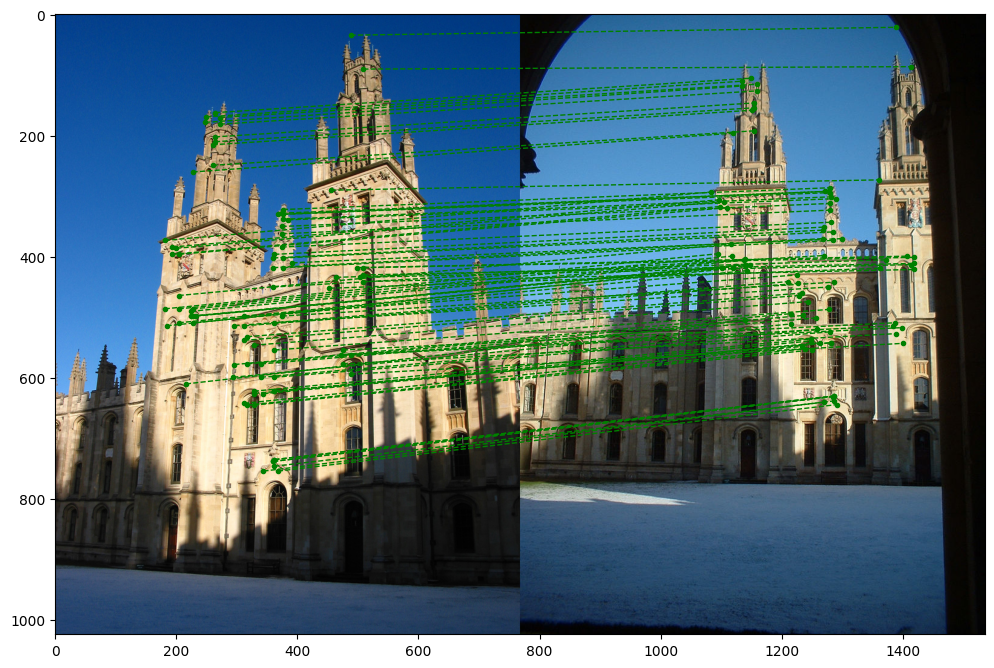

In [271]:
def plot_corrs(
    qimg, dbimg, qbbx=None, qdata=None, dbdata=None, inl=None, H=None
):
    _, _, q_centroid_ids, qx, qy, qs, q_residuals = qdata.get()
    _, _, db_centroid_ids, dbx, dby, dbs, db_residuals = dbdata.get()
    
    corrs, _ = get_tentative_correspondencies(
        q_centroid_ids, db_centroid_ids, q_residuals, db_residuals, kernel_similarity
    )
    
    bbx, bby, *_ = qbbx if qbbx is not None else [0, 0]
    
    scales1 = scales[qs[corrs[:, 0]]]
    qx = (qx[corrs[:, 0]] * 16 / scales1) + bbx
    qy = (qy[corrs[:, 0]] * 16 / scales1) + bby

    scales2 = scales[dbs[corrs[:, 1]]]
    dbx = dbx[corrs[:, 1]] * 16 / scales2
    dby = dby[corrs[:, 1]] * 16 / scales2
    
    plt.figure(figsize=(12, 12))
    qh, qw, _ = qimg.shape
    dbh, dbw, _ = dbimg.shape
    
    img = np.zeros([max(qh, dbh), qw + dbw, 3], dtype=int)
    img[:qh, :qw] = qimg
    img[:dbh, qw:] = dbimg
    
    _q_pts = np.vstack([qx, qy, np.ones_like(qx)])
    _transformed = H @ _q_pts
    _transformed /= _transformed[-1]
    tdbx, tdby, _ = _transformed
    
    print('Num of inliers:', inl.sum())
    if all(i is not None for i in [qx, qy, dbx, dby, inl]):
        for i, (x1, y1, x2, y2, c, inlier) in enumerate(zip(
            qx, qy, dbx, dby, cycle(mcolors.TABLEAU_COLORS.values()), inl
        )):
            if not inlier:
                continue
            plt.plot(
                # [int(x1), int(x2 + qw), int(tdbx[i] + qw)],
                # [int(y1), int(y2), int(tdby[i])],
                [int(x1), int(tdbx[i] + qw)],
                [int(y1), int(tdby[i])],
                color='green',
                marker='o',
                linestyle='dashed',
                linewidth=1,
                markersize=3,
            )
    
    plt.imshow(img)
    plt.show()
    

plot_corrs(
    query_img,
    result_img,
    gnd['gnd'][QID]['bbx'],
    query_iterator.get_item(QID),
    db_iterator.get_item(DBID),
    mask,
    H, #np.linalg.inv(H),
)

---

Replication of AntoRH

In [179]:
N1 = np.array([
    [.5, .1, 10],
    [.1, .5, 20],
    [0, 0, 1],
])
N2 = np.array([
    [.7, 0, 150],
    [0, .8, 250],
    [0, 0, 1],
])
N3 = np.array([
    [.6, .1, 55],
    [0, .7, 45],
    [0, 0, 1],
])
N4 = np.array([
    [.5, .1, 45],
    [0, .4, 20],
    [0, 0, 1],
])
D1 = np.array([
    [2, 0, 40],
    [.3, 3, 70],
    [0, 0, 1],
])
D2 = np.array([
    [1, 0, 110],
    [.1, 2, 90],
    [0, 0, 1],
])
D3 = np.array([
    [1.5, 0, 115],
    [.2, 1.7, 235],
    [0, 0, 1],
])
D4 = np.array([
    [1.8, 0, 200],
    [.1, 1.7, 185],
    [0, 0, 1],
])

Ns = np.vstack([N1, N2, N3, N4]).reshape([-1, 3, 3])  # ??np.stack
Ds = np.vstack([D1, D2, D3, D4]).reshape([-1, 3, 3])

In [224]:
AntoRH(Ns, Ds)

array([[ 1.93390663e-01, -4.37598405e-02,  1.18784984e-01],
       [ 5.95668310e-01, -2.63953887e-01,  7.76739238e+00],
       [ 1.62224621e-03,  1.83320738e-04,  3.43451401e-02]])

---

In [15]:
QID = 0
DBID = gnd['gnd'][QID]['easy'][0]

In [16]:
supp, A, mask = pure_sv(query_iterator.get_item(QID), db_iterator.get_item(DBID))
supp, mask.sum()

(8.65625, 31)

Num of inliers: 31


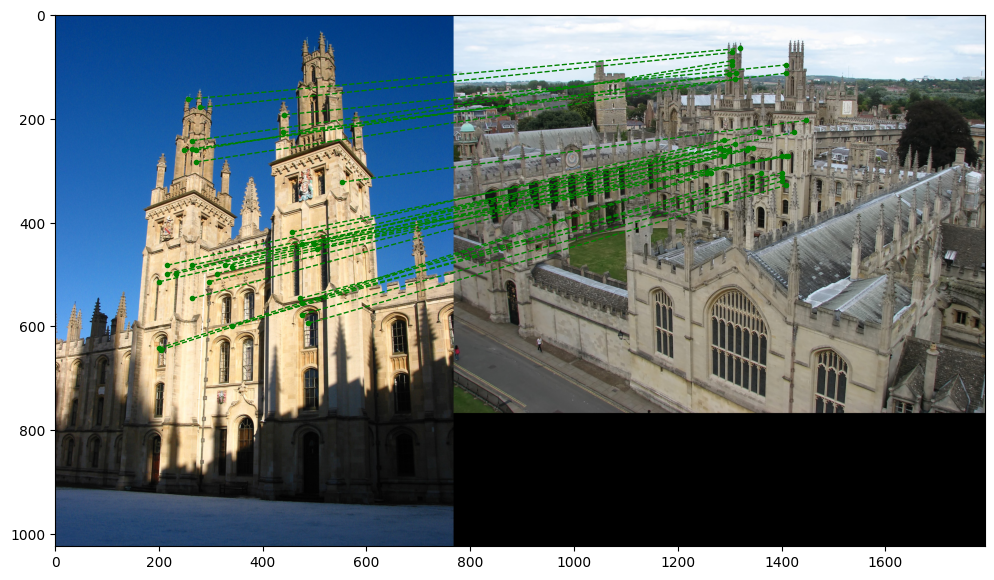

In [21]:
query_img_name = gnd['qimlist'][QID]
result_img_name = gnd['imlist'][DBID]

query_img = plt.imread(IMAGES_ROOT / f'{query_img_name}.jpg')
result_img = plt.imread(IMAGES_ROOT / f'{result_img_name}.jpg')

plot_corrs(
    query_img,
    result_img,
    gnd['gnd'][QID]['bbx'],
    query_iterator.get_item(QID),
    db_iterator.get_item(DBID),
    mask,
)